# Word embeddings
- Word Embeddings es una técnica popular en procesamiento del lenguaje natural que permite representar las palabras en un espacio vectorial,

- Dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

## 1.- Conjuntos de entrenamiento y validación

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv('./cyberbullying_tweets.csv')   

In [34]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [35]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [36]:
# Contar elementos por clase
count = df['cyberbullying_type'].value_counts()
count

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [37]:
from sklearn.model_selection import train_test_split
train_df, val_df= train_test_split(df, test_size = 0.15, random_state = 123)

In [38]:
train_df['cyberbullying_type'].value_counts()

cyberbullying_type
not_cyberbullying      6826
gender                 6821
ethnicity              6777
age                    6763
religion               6743
other_cyberbullying    6608
Name: count, dtype: int64

## 2.- Preprocesamiento

In [40]:
# Creamos un diccionario que mapea cada etiqueta a un número entero
labels_dict = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

# Usamos la función map() para reemplazar cada etiqueta con su valor entero correspondiente
train_df['cyberbullying_type'] = train_df['cyberbullying_type'].replace(labels_dict)
val_df['cyberbullying_type'] = val_df['cyberbullying_type'].replace(labels_dict)

train_df.head()

,tweet_text,cyberbullying_type
32620,If you’re in college and still posting about t...,4
9173,"but, there is still the dolly magazine model c...",1
1466,Why am I disappointed?,0
32887,What was the conversation was leading up to th...,4
15856,"“faces up to three years in prison” , “getting...",1


- Verifica cadenas vacias

In [41]:
train_df['tweet_text'].isna().sum()

0

- Elimina puntuación y convierte a minúsculas
- Se utiliza el método __str.translate()__ para eliminar todos los caracteres de puntuación mediante una tabla de traducción creada con el método __str.maketrans__. La constante string.punctuation contiene todos los caracteres de puntuación ASCII, que se eliminan de los valores en la columna

In [42]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [43]:
train_df['tweet_text'] = train_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
train_df.head()

,tweet_text,cyberbullying_type
32620,if you’re in college and still posting about t...,4
9173,but there is still the dolly magazine model co...,1
1466,why am i disappointed,0
32887,what was the conversation was leading up to th...,4
15856,“faces up to three years in prison” “getting ...,1


In [44]:
val_df['tweet_text'] = val_df['tweet_text'].str.lower().str.translate(str.maketrans('', '', string.punctuation))
val_df.head()

,tweet_text,cyberbullying_type
22180,too true their radical anti family anti bible ...,2
1399,this book was published in 2008,0
14950,rt strubbestition im not sexist but personal o...,1
17013,dianh4 exposefalsehood who else are we suppose...,2
45351,lmao u dumb rt k11agee what is the ciaa colore...,5


## 2.- Pipeline

In [45]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras import layers 
import re

X_train = train_df['tweet_text'].values
y_train = train_df['cyberbullying_type'].values

X_val = val_df['tweet_text'].values
y_val = val_df['cyberbullying_type'].values

In [46]:
len(X_train), len(X_val)

(40538, 7154)

In [47]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
raw_val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))

for text in raw_train_ds.take(1):
    print(text)

(<tf.Tensor: shape=(), dtype=string, numpy=b'if you\xe2\x80\x99re in college and still posting about the girl you had \xe2\x80\x9cbeef\xe2\x80\x9d with and bullied in high school on an insta spam page you\xe2\x80\x99re straight up trash move tf on sis'>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)


In [48]:
# Tamaño de vocabulario
vocab_size = 10000

vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size,
    output_mode='int')

# Obtener el texto sin etiquetas
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [49]:
# Define a function to convert the label to a one-hot encoding
def convert_label_to_one_hot(text, label):
    one_hot_label = tf.one_hot(label, 6)
    return text, one_hot_label

# Apply the function to the dataset using map()
raw_train_ds = raw_train_ds.map(convert_label_to_one_hot)
raw_val_ds = raw_val_ds.map(convert_label_to_one_hot)

In [50]:
batch_size = 32
train_ds = raw_train_ds.shuffle(33384).batch(batch_size)
val_ds = raw_val_ds.batch(batch_size)

In [51]:
for inp, target in train_ds.take(1):
    print(inp, target)

tf.Tensor(
[b'had a nice run in with bill bennett on campus he was unaware that his ministry is responsible for local governance here'
 b'cant believe im still awake when i  have to wake up in 4 hours time for school but school until 11 only tmr \xf0\x9f\x98\x84'
 b'a very busy morning at the museum with a school group a photography group and group from thecooperative evening lecture still to come'
 b'12 have you ever heard of useful idiots amp agent provocateurs now here to discredit blacklivesmatter just likegtgtgtyou do know 5th columnists like hamas originally a creation of israel with muslim brotherhood to split the palestinian struggle plo amp directly against fatah pflp'
 b'truaemusic mattybboi83 number10gov what are you talking about'
 b'i hate the word reclaiming bc it sounds childish but its the only word i can think of right now to describe how ive gotten my free will and independent identity back i am a free woman in christ not a christian woman chained by her church'
 b'ge

In [52]:
vectorize_layer(inp)

<tf.Tensor: shape=(32, 55), dtype=int64, numpy=
array([[ 113,    3,  405, ...,    0,    0,    0],
       [ 141,  249,   50, ...,    0,    0,    0],
       [   3,  225, 1912, ...,    0,    0,    0],
       ...,
       [7883, 4775, 2994, ...,    0,    0,    0],
       [ 229, 1635,   73, ...,    0,    0,    0],
       [7610,    6,   73, ...,    0,    0,    0]], dtype=int64)>

## 3.- Modelo

In [53]:
model = Sequential([
  vectorize_layer,
  layers.Embedding(vocab_size, 128, name="embedding"),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(16, activation='relu'),
  layers.Dense(6)
])

lr = 0.0001
opt = tf.keras.optimizers.Adam(learning_rate=lr)

In [54]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=opt,
              metrics=['accuracy'])

In [55]:
model(inp)

<tf.Tensor: shape=(32, 6), dtype=float32, numpy=
array([[-1.71611004e-03,  1.20178675e-02, -1.86494412e-03,
         2.11396813e-02, -5.28508704e-03, -9.98621993e-03],
       [-2.00704578e-03,  1.20088411e-02, -1.00003288e-03,
         2.09495574e-02, -4.83734393e-03, -9.64606740e-03],
       [-2.09410815e-03,  1.24992998e-02, -2.34186719e-03,
         2.34436598e-02, -5.42774424e-03, -1.05292369e-02],
       [ 1.52328575e-04,  6.92556472e-03,  4.52062930e-04,
         7.46289408e-03, -4.95623425e-03, -5.23013389e-03],
       [-3.40922736e-03,  1.81935132e-02, -2.78282957e-03,
         3.41107287e-02, -8.02877918e-03, -1.50808441e-02],
       [-7.82715724e-05,  3.27933067e-03,  1.00895108e-04,
         4.54865303e-03, -1.13765337e-03, -2.93196621e-03],
       [-2.23579421e-03,  1.32595217e-02, -4.71671345e-03,
         2.90168542e-02, -5.43333497e-03, -1.20801581e-02],
       [ 8.74928955e-04,  5.38261142e-03, -4.46042279e-03,
         1.44201713e-02, -1.33273343e-03, -7.17403926e-03],

In [56]:
epochs = 7
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/7
1267/1267 [==============================] - 7s 5ms/step - loss: 1.6414 - accuracy: 0.3492 - val_loss: 1.3830 - val_accuracy: 0.4788
Epoch 2/7
1267/1267 [==============================] - 6s 4ms/step - loss: 1.1092 - accuracy: 0.6144 - val_loss: 0.8868 - val_accuracy: 0.7119
Epoch 3/7
1267/1267 [==============================] - 6s 4ms/step - loss: 0.7445 - accuracy: 0.7430 - val_loss: 0.6468 - val_accuracy: 0.7599
Epoch 4/7
1267/1267 [==============================] - 6s 4ms/step - loss: 0.5830 - accuracy: 0.7764 - val_loss: 0.5548 - val_accuracy: 0.7716
Epoch 5/7
1267/1267 [==============================] - 6s 5ms/step - loss: 0.5133 - accuracy: 0.7912 - val_loss: 0.5119 - val_accuracy: 0.7886
Epoch 6/7
1267/1267 [==============================] - 6s 5ms/step - loss: 0.4768 - accuracy: 0.8040 - val_loss: 0.4909 - val_accuracy: 0.7937
Epoch 7/7
1267/1267 [==============================] - 6s 5ms/step - loss: 0.4542 - accuracy: 0.8145 - val_loss: 0.4787 - val_accuracy: 0.7916

## 4.- Evaluación

In [57]:
model.evaluate(val_ds)

224/224 [==============================] - 1s 4ms/step - loss: 0.4787 - accuracy: 0.7916


[0.47874006628990173, 0.7915851473808289]

In [58]:
x_test, y_test = next(iter(val_ds))
x_test.shape, y_test.shape

(TensorShape([32]), TensorShape([32, 6]))

In [59]:
model.layers

In [120]:
words = 'boomer black muslim catholic religion asian chinese china afro african old young immature inexperience women men childish yellow nigga nigger kitchen islam obama trump mexican LGBT lesbian gay trans dark femenine poof homo nancy fairy pansy queen dyke fag god ape cotton eggplant monkey '
ids = model.layers[0]([words])
embeddings = model.layers[1](ids)
embeddings

<tf.Tensor: shape=(1, 44, 128), dtype=float32, numpy=
array([[[-0.06776918, -0.03036616,  0.02647226, ..., -0.15432985,
          0.13737239, -0.00166553],
        [-0.20702492,  0.21697265, -0.23359275, ...,  0.25016508,
          0.37956855, -0.39918777],
        [-0.329069  , -0.20193923, -0.38064116, ...,  0.33575016,
          0.42067462, -0.40502322],
        ...,
        [-0.02076153,  0.03430504, -0.06277589, ..., -0.01039262,
          0.04620405,  0.01994292],
        [-0.06776918, -0.03036616,  0.02647226, ..., -0.15432985,
          0.13737239, -0.00166553],
        [-0.04282129,  0.02105879,  0.00567982, ...,  0.05310455,
          0.11818656, -0.06400306]]], dtype=float32)>

- Visualización de los vectores aprendidos

(44, 2)


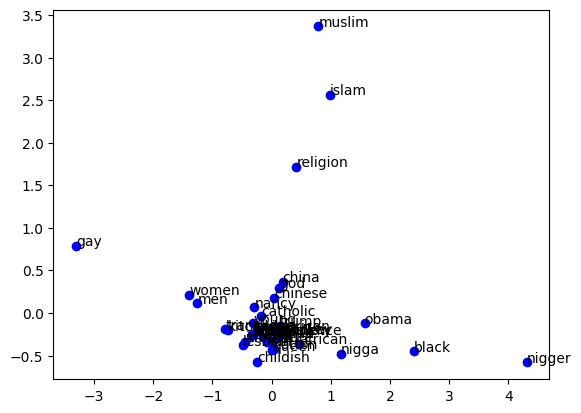

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import tensorflow as tf


# Perform PCA on embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings[0])
print(pca_embeddings.shape)

# Plot embeddings using matplotlib
fig, ax = plt.subplots()
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='o', c='b')

for i, word in enumerate(words.split()):
    ax.annotate(word, (pca_embeddings[i, 0], pca_embeddings[i, 1]))
    
plt.show()